In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import requests
# from astroquery import sdss
import SciServer.CasJobs as CasJobs # query with CasJobs, the primary database for the SDSS
import SciServer.SkyServer as SkyServer # show individual objects through SkyServer
import SciServer.SciDrive
import warnings
from PIL import Image
import glob
warnings.filterwarnings('ignore')

In [2]:
# want to access bright objects from the PCC
df0 = pd.read_fwf('..\PCC_cat.txt', header=None)
df0

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,PCC-0001,49.2355,41.5722,20.51,0.04,1.44,0.10,20.80,1.07,...,0.69,0.25,0.63,0.28,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
1,NaN,PCC-0002,49.2366,41.4013,20.44,0.04,2.18,0.14,21.96,0.79,...,1.53,1.01,1.38,0.97,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
2,NaN,PCC-0003,49.2370,41.4336,21.58,0.04,1.11,0.07,22.41,0.07,...,1.25,0.71,1.19,0.67,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
3,NaN,PCC-0004,49.2377,41.5285,21.03,0.06,1.08,0.10,23.14,0.69,...,0.58,0.25,0.42,0.15,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
4,NaN,PCC-0005,49.2380,41.4346,20.27,0.02,1.24,0.04,21.94,0.80,...,0.70,0.50,0.53,0.48,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5432,NaN,PCC-5433,50.0062,41.2380,20.32,NaN,1.10,NaN,22.53,3.80,...,0.97,0.83,0.93,0.69,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5433,NaN,PCC-5434,50.0064,41.2568,22.63,NaN,0.54,NaN,23.29,0.50,...,1.46,1.12,NaN,NaN,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5434,NaN,PCC-5435,50.0068,41.6048,21.44,0.02,0.61,0.02,21.52,0.43,...,0.59,0.41,NaN,NaN,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5435,NaN,PCC-5436,50.0070,41.3916,21.32,0.07,0.99,0.10,22.86,0.95,...,1.19,1.07,1.06,0.92,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...


In [3]:
## Unused??? to check balance of labels within dataframe
# def checkBalance(df):
#     all_labels = df['labels']
#     all_labels = all_labels.tolist()
#     balance = df['labels'].value_counts()
#     print(balance)
#     for i in range(len(balance)):
#         print(f'{balance[i]*100/df.size:.2f} %')

In [4]:
checks = [1078, 1613, 3164, 3672, 3742, 3921, 4330] ## PCC Objects that we wanted to see the data of

i = np.where((df0[1] == 'PCC-1078') | (df0[1] == 'PCC-1613') | (df0[1] == 'PCC-3164') | (df0[1] == 'PCC-3672') | \
            (df0[1] == 'PCC-3742') | (df0[1] == 'PCC-3921') | (df0[1] == 'PCC-4330'))
df0.iloc[i]

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
1077,NaN,PCC-1078,49.4284,41.5999,16.87,0.00,7.74,0.03,22.80,1.58,...,0.67,0.53,0.66,0.51,NaN,NaN,Likely dE/ETGcluster candidate,NaN,Nucleated,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
1612,NaN,PCC-1613,49.5126,41.5128,17.37,0.00,6.33,0.02,22.52,1.29,...,0.63,0.44,0.63,0.41,NaN,NaN,Likely dE/ETGcluster candidate,NaN,Nucleated,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
3163,NaN,PCC-3164,49.7177,41.2676,16.60,0.00,9.30,0.04,23.25,1.77,...,0.66,0.50,0.67,0.48,NaN,NaN,Likely dE/ETGcluster candidate,NaN,Nucleated,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
3671,NaN,PCC-3672,49.7827,41.4127,17.25,0.00,7.57,0.03,22.44,1.33,...,0.62,0.49,0.58,0.48,NaN,NaN,Likely dE/ETGcluster candidate,Unsure,about nucleation,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
3741,NaN,PCC-3742,49.7926,41.6781,17.51,0.00,5.42,0.02,22.89,1.88,...,0.67,0.54,0.66,0.55,NaN,NaN,Likely dE/ETGcluster candidate,Unsure,about nucleation,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
3920,NaN,PCC-3921,49.8126,41.2313,17.85,0.01,8.64,0.12,23.45,1.69,...,0.64,0.47,0.63,0.46,NaN,NaN,Likely dE/ETGcluster candidate,NaN,Nucleated,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
4329,NaN,PCC-4330,49.8627,41.6082,17.60,0.00,6.19,0.02,23.01,1.40,...,0.63,0.49,0.63,0.50,NaN,NaN,Likely dE/ETGcluster candidate,NaN,Nucleated,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...


In [5]:
# threshold for the r-band -- the lower the brighter
rmag_threshold = 19.4
bright = np.where(df0[4] <= rmag_threshold)
brightDF = df0.iloc[bright].copy()
# # brightDF
# faint = np.where( (df0[4] >= rmag_threshold) & (df0[4] < 20 ))
# faintDf = df0.iloc[faint].copy()
brightDF


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
5,NaN,PCC-0006,49.2388,41.4631,19.03,0.00,0.69,0.01,19.28,1.35,...,0.39,-0.11,NaN,NaN,NaN,NaN,Likely merging system,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
6,NaN,PCC-0007,49.2392,41.4215,19.26,0.03,0.97,0.05,20.76,3.79,...,1.02,0.68,0.88,0.66,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
7,NaN,PCC-0008,49.2411,41.4991,18.51,0.01,1.78,0.02,20.95,2.50,...,1.01,0.82,0.93,0.66,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
10,NaN,PCC-0011,49.2420,41.4454,19.19,0.01,1.51,0.02,21.95,1.02,...,0.83,0.59,0.70,0.47,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
25,NaN,PCC-0026,49.2466,41.4451,19.34,0.01,2.04,0.02,21.31,1.20,...,1.18,0.85,0.98,0.75,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5386,NaN,PCC-5387,49.9985,41.3856,18.60,0.01,2.84,0.06,22.78,2.45,...,0.88,0.70,0.82,0.65,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5407,NaN,PCC-5408,50.0018,41.6806,18.16,0.00,0.16,0.00,15.85,3.30,...,0.24,0.12,NaN,NaN,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5416,NaN,PCC-5417,50.0028,41.3384,18.84,0.01,1.27,0.02,20.74,2.42,...,1.05,0.75,0.78,0.71,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5422,NaN,PCC-5423,50.0040,41.3410,17.50,0.01,1.86,0.02,20.45,4.00,...,0.92,0.76,0.93,0.69,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...


In [6]:
labels = np.unique(brightDF[21])

# access ra and dec from their columns in the dataframe
names = brightDF[1]
ra = brightDF[2]
dec = brightDF[3]

filenames = []
for r, d in zip(ra, dec):
    fn = f'sdss_ra={r}_dec={d}.png'
    filenames.append(fn)

brightDF_reduced = pd.DataFrame({'files' : filenames,
                                 'name': names,
                                 'labels': brightDF[21],
                                 'ra': ra,
                                 'dec': dec})

# brightDF_reduced = pd.DataFrame({'name': names,
#                                  'ra':ra,
#                                  'dec':dec})
# brightDF_reduced

In [7]:
## Copying logic from the reduction of labels to binary

# checkBalance(brightDF_reduced)
df1 = brightDF_reduced
unique_labels = np.unique(df1['labels'])

clusterBG_LTG = df1.loc[(df1['labels']==unique_labels[0])]
BG_ETG = df1.loc[(df1['labels']==unique_labels[1])]
clusterBG_edgeDisk = df1.loc[(df1['labels']==unique_labels[2])]
likely_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[3])]
likely_merging = df1.loc[(df1['labels']==unique_labels[4])]
poss_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[5])]
weak_bg = df1.loc[(df1['labels']==unique_labels[6])]

downSampleDf0 = pd.concat([clusterBG_LTG, # 384
                         BG_ETG.sample(frac = 400/3008),
                         clusterBG_edgeDisk.sample(frac = 400/1049),
                         likely_dE_ETGcluster, # 398
                         likely_merging, # 23
                         poss_dE_ETGcluster, # 98
                         weak_bg # 477
                         ])
# checkBalance(downSampleDf0)

def replace(df, ind):
    label = list(df['labels'])[0]
    newDf = df.replace(label, str(ind))
    return(newDf)


# combined 3 and 5
second = pd.concat([
                    replace(likely_dE_ETGcluster, 1), # old 3
                    replace(poss_dE_ETGcluster, 1) # old 5
                    ])
# combine 0,1,2,6
first = pd.concat([replace(clusterBG_LTG, 0), # old 0
                   replace(BG_ETG, 0), # old 1
                   replace(clusterBG_edgeDisk, 0), # old 2
                   replace(weak_bg, 0) # old 6
                    ])

lenSecond = len(second.index)
lenFirst = len(first.index)

downSampleDf1 = pd.concat([first.sample(frac = lenSecond/lenFirst), second])

# 0 is background
# 1 is dE/ETGcluster


# remove red contaminants / hot pixel images
downFiles = downSampleDf1['files']
redPercent = [None]*len(downFiles)
counter = 0
workDir = '../Images/SDSS-png/'

# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 80, 20])
upper1 = np.array([10, 255, 255])
 
# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160, 100, 20])
upper2 = np.array([179, 255, 255])

for i, x in enumerate(downFiles):
    testImgPath = os.path.join(workDir, x)
    image = cv2.imread(testImgPath)
    result = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_mask = cv2.inRange(image, lower1, upper1)
    upper_mask = cv2.inRange(image, lower2, upper2)
    full_mask = lower_mask + upper_mask;

    result = cv2.bitwise_and(result, result, mask=full_mask)
    dim = np.shape(full_mask)[0] 
    counts = np.count_nonzero(full_mask)
#     print(counts)
#     print(dim**2)
    percent = 100*counts/dim**2
    redPercent[i] = percent
    subtitle_string = f'{percent}% of the image is red'
    filename = testImgPath.split('\\')[-1]
#     print(f'{filename}, {subtitle_string}')
#     if percent > 50.0:
#         counter += 1
# #         print('To be removed')
#     else:
#         pass

downSampleDf1['reds'] = redPercent # add new column of the red percentage of an image
# downSampleDf1
redList = (downSampleDf1['reds'] >= 50) # percentage threshold of how much red is in the image
# downSampleDf1.shape
df_filtered = downSampleDf1[downSampleDf1['reds'] <= 50]
df_filtered.shape

(229, 6)

In [8]:
# shuffle order of columns for crossmatch order (ra and dec must be last)
df_filtered = df_filtered.iloc[:,[0, 1, 2, 5, 3, 4]]
df_filtered


,files,name,labels,reds,ra,dec
4968,sdss_ra=49.9437_dec=41.3786.png,PCC-4969,0,7.0100,49.9437,41.3786
944,sdss_ra=49.4063_dec=41.4087.png,PCC-0945,0,42.1200,49.4063,41.4087
2078,sdss_ra=49.5877_dec=41.3917.png,PCC-2079,0,3.2900,49.5877,41.3917
4871,sdss_ra=49.9322_dec=41.6483.png,PCC-4872,0,7.6800,49.9322,41.6483
3233,sdss_ra=49.726_dec=41.2954.png,PCC-3234,0,0.0475,49.7260,41.2954
...,...,...,...,...,...,...
5338,sdss_ra=49.9932_dec=41.5479.png,PCC-5339,1,28.4075,49.9932,41.5479
5357,sdss_ra=49.9947_dec=41.75.png,PCC-5358,1,49.0425,49.9947,41.7500
5373,sdss_ra=49.9967_dec=41.3092.png,PCC-5374,1,17.3550,49.9967,41.3092
4501,sdss_ra=49.8825_dec=41.7447.png,PCC-4502,1,4.6300,49.8825,41.7447


In [9]:
# this is the input csv to the crossmatch
df_filtered.to_csv('brightPCC.csv', index = False)
df_filtered

,files,name,labels,reds,ra,dec
4968,sdss_ra=49.9437_dec=41.3786.png,PCC-4969,0,7.0100,49.9437,41.3786
944,sdss_ra=49.4063_dec=41.4087.png,PCC-0945,0,42.1200,49.4063,41.4087
2078,sdss_ra=49.5877_dec=41.3917.png,PCC-2079,0,3.2900,49.5877,41.3917
4871,sdss_ra=49.9322_dec=41.6483.png,PCC-4872,0,7.6800,49.9322,41.6483
3233,sdss_ra=49.726_dec=41.2954.png,PCC-3234,0,0.0475,49.7260,41.2954
...,...,...,...,...,...,...
5338,sdss_ra=49.9932_dec=41.5479.png,PCC-5339,1,28.4075,49.9932,41.5479
5357,sdss_ra=49.9947_dec=41.75.png,PCC-5358,1,49.0425,49.9947,41.7500
5373,sdss_ra=49.9967_dec=41.3092.png,PCC-5374,1,17.3550,49.9967,41.3092
4501,sdss_ra=49.8825_dec=41.7447.png,PCC-4502,1,4.6300,49.8825,41.7447


## This part should be automate-able with SDSS-query

In [10]:
# output csv from crossmatch
bright_csv = '../Sheets/PCC_CrossMatch.csv'
brightDF1 = pd.read_csv(bright_csv, skiprows = 1)
brightDF1

,files,name,labels,reds,objID,type,ra,dec,modelMag_r,u_g,g_z,g_r,g_i,r_i,r_z,petroRad_r
0,sdss_ra=49.9985_dec=41.3856.png,PCC-5387,0,3.3975,1237661055281858002,GALAXY,49.998486,41.385606,18.58372,2.330160,2.217403,1.269188,1.837666,0.568478,0.948215,5.380006
1,sdss_ra=49.5411_dec=41.5389.png,PCC-1795,0,6.0250,1237661055281661552,GALAXY,49.541127,41.538935,17.08435,1.635536,1.695250,0.960300,1.370968,0.410667,0.734949,10.597430
2,sdss_ra=49.6769_dec=41.3202.png,PCC-2835,0,5.0100,1237661122387968404,GALAXY,49.676896,41.320255,23.41172,1.138586,0.929184,-2.633751,0.937946,3.571697,3.562935,0.209667
3,sdss_ra=49.6116_dec=41.197.png,PCC-2283,0,1.5825,1237661083199210860,GALAXY,49.611574,41.197021,19.48380,1.099449,1.053764,0.697296,0.955110,0.257814,0.356468,2.064733
4,sdss_ra=50.0028_dec=41.3384.png,PCC-5417,0,3.2525,1237661055281857479,GALAXY,50.002733,41.338369,18.87916,2.246117,2.017632,1.125536,1.634195,0.508659,0.892096,2.361201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,sdss_ra=49.9932_dec=41.5479.png,PCC-5339,1,28.4075,1237661059574334453,STAR,50.017209,41.548275,21.31716,0.580925,3.674906,1.534445,2.881615,1.347170,2.140461,3.350529
226,sdss_ra=49.9947_dec=41.75.png,PCC-5358,1,49.0425,1237670960021504409,GALAXY,49.994725,41.750034,17.53399,6.157221,1.576391,0.871559,1.323565,0.452005,0.704832,8.789475
227,sdss_ra=49.9967_dec=41.3092.png,PCC-5374,1,17.3550,1237661055281857031,STAR,49.996200,41.309363,22.91631,1.041622,1.991064,1.159723,1.114315,-0.045408,0.831341,1.055185
228,sdss_ra=49.8825_dec=41.7447.png,PCC-4502,1,4.6300,1237670458048446875,GALAXY,49.882513,41.744532,19.29449,3.955753,-0.534899,0.685694,1.386385,0.700691,-1.220592,7.691484


In [11]:
# brightDF2 = display(brightDF1.loc[(brightDF1['modelMag_r'] < 17.3) & (brightDF1['u_g'] < 2.5)])

brightDF2 = brightDF1.loc[(brightDF1['modelMag_r'] < rmag_threshold) \
                          & (brightDF1['u_g'] < 2.5) \
#                           & (brightDF1['petroRad_r'] < 50) \ # weird incredibly high petroRad_r?
                          & (brightDF1['g_z'] < 2.2)]
# brightDF2 = brightDF1.loc[(brightDF1['modelMag_r'] < rmag_threshold)]

# pairDf = brightDF2[['ra', 'dec', 'u_g', 'g_z', 'g_r', 'g_i', 'r_i', 'r_z', 'modelMag_r','petroRad_r','labels']]
pairDf = brightDF2[['u_g', 'g_z', 'g_r', 'g_i', 'r_i', 'r_z', 'modelMag_r','labels']]
pairDf

,u_g,g_z,g_r,g_i,r_i,r_z,modelMag_r,labels
1,1.635536,1.695250,0.960300,1.370968,0.410667,0.734949,17.08435,0
4,2.246117,2.017632,1.125536,1.634195,0.508659,0.892096,18.87916,0
8,1.262079,0.737644,0.458859,0.649113,0.190254,0.278786,18.66884,0
11,1.302483,0.792460,0.511456,0.713074,0.201617,0.281004,15.49529,0
12,1.617607,2.170547,1.181578,1.761650,0.580072,0.988970,19.18396,0
...,...,...,...,...,...,...,...,...
219,1.302105,1.511499,0.821907,1.175476,0.353569,0.689592,19.37686,1
220,1.974316,1.445345,0.867374,1.316496,0.449122,0.577971,18.71980,1
222,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,14.49405,1
223,1.906456,1.674442,0.899385,1.351961,0.452576,0.775057,15.59959,1


In [12]:

# brightDF2 = brightDF1.query('modelMag_r < 17.3')
# brightDF3 = brightDF2.query('u_g < 2.5')
# brightDF3


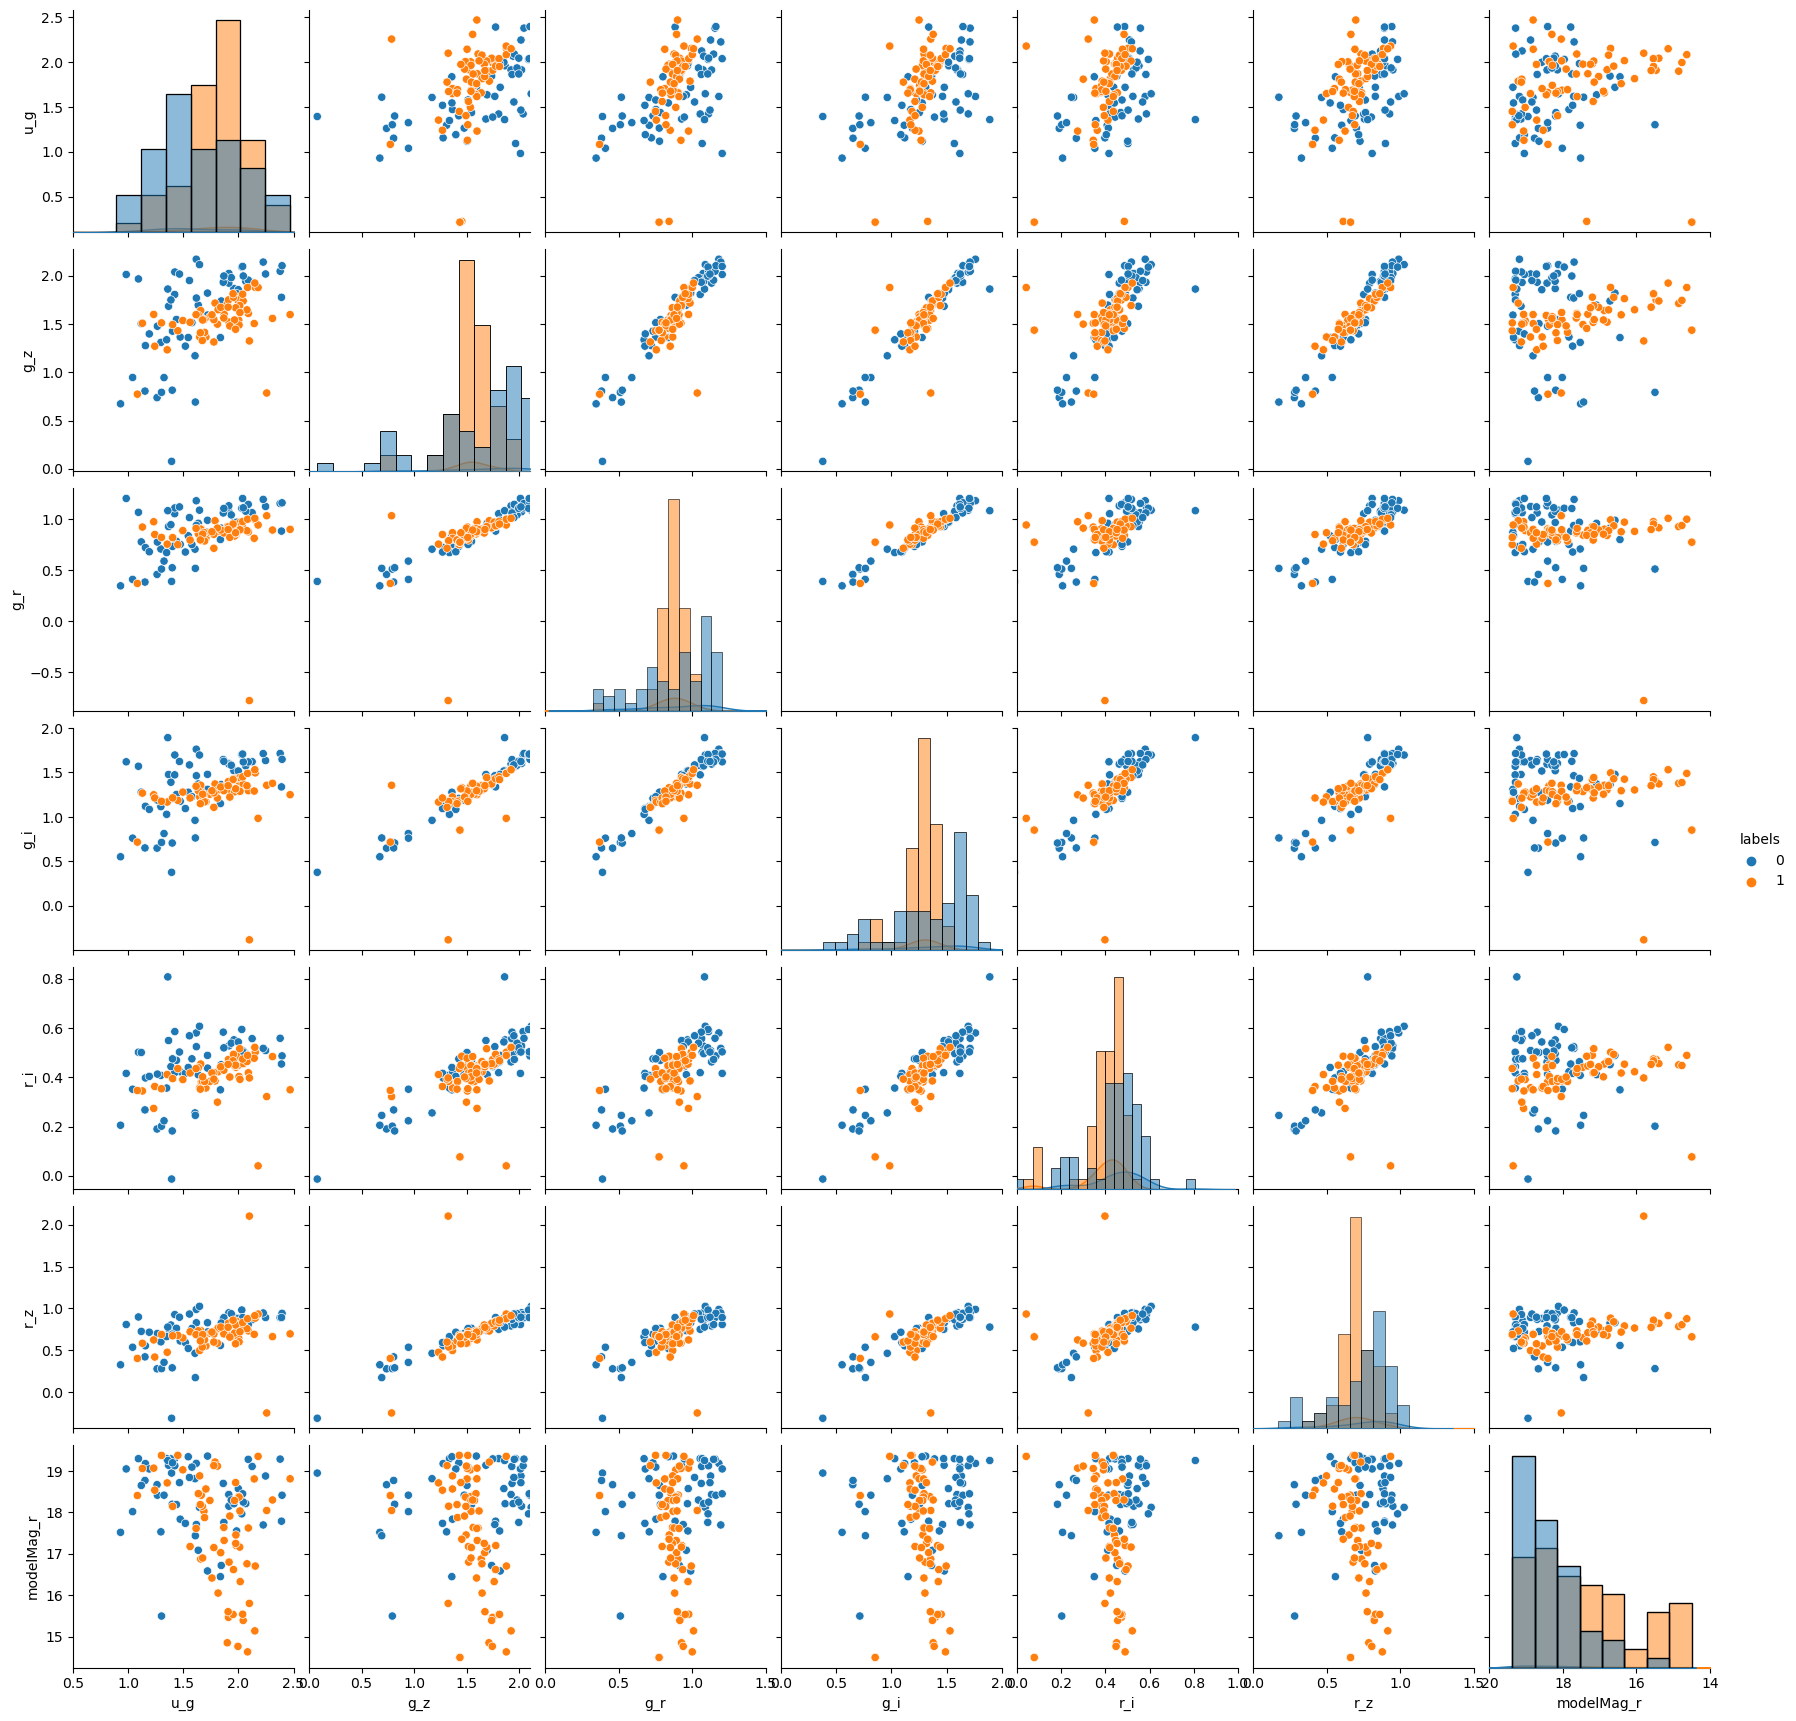

In [13]:

# gz_lim = (1.25, 2.00)
ug_lim = (.5, 2.5)
gz_lim = (0, 2.1)
gr_lim = (0, 1.5)
gi_lim = (0, 2.0)
ri_lim = (0, 1.0)
rz_lim = (0, 1.5)
modMagr_lim = (14.0, 20)
petroRad_r_lim = (0, 20)

# Uncomment for big pairplot:
p1 = sns.pairplot(pairDf, corner = False, hue = 'labels')
p1.map_diag(sns.histplot)

## set column x lims
p1.axes[0, 0].set_xlim(ug_lim)
p1.axes[0, 1].set_xlim(gz_lim)
p1.axes[0, 2].set_xlim(gr_lim)
p1.axes[0, 3].set_xlim(gi_lim)
p1.axes[0, 4].set_xlim(ri_lim)
p1.axes[0, 5].set_xlim(rz_lim)
p1.axes[0, 6].set_xlim(modMagr_lim[::-1])
# p1.axes[0, 3].set_xlim(petroRad_r_lim[::-1])

# # ## set row y lims
# p1.axes[0, 0].set_xlim(ug_lim)
# p1.axes[1, 0].set_xlim(gz_lim)
# p1.axes[2, 0].set_xlim(gr_lim)
# p1.axes[3, 0].set_xlim(gi_lim)
# p1.axes[4, 0].set_xlim(ri_lim)
# p1.axes[5, 0].set_xlim(rz_lim)
# p1.axes[6, 0].set_xlim(modMagr_lim[::-1])

# p1.axes[6, 0].set_ylim(modMagr_lim[::-1])
# p1.axes[3, 0].set_ylim(petroRad_r_lim[::-1])
plt.savefig('../Images/WriteUpFigs/color-pairplot-all.png')

In [14]:
# p2 = sns.pairplot(pairDf, hue = 'labels', corner = True, kind = 'kde')

In [15]:
# x1 = pairDf['u_g']
# x2 = pairDf['g_z']
# plt.figure()
# plt.plot(x1, x2, 'o')
# plt.xlabel('u_g')
# plt.ylabel('g_z')

In [17]:
# # x_vars = ["u_g", "g_z", "modelMag_r", "petroRad_r"]
# x_vars = ["u_g", "g_z", "petroRad_r"]
# y_vars = ["modelMag_r"]
# g = sns.PairGrid(pairDf, hue="labels", x_vars=x_vars, y_vars=y_vars, height = 3)
# # g.map_diag(sns.histplot, color=".3")
# g.map_offdiag(sns.scatterplot)
# g.add_legend()
# # g.axes[0, 0].set_ylim(modMagr_lim[::-1])
# # g.axes[0, 0].set_xlim(ug_lim[::-1])
# # g.axes[0, 0].set_xlim(ug_lim[::-1])

# # g.axes[0, 1].set_xlim(gz_lim[::-1])
# g.axes[0, 2].set_xlim(petroRad_r_lim)

In [19]:
# x_vars = ["g_z", "modelMag_r", "petroRad_r"]
# y_vars = ["u_g"]
# f = sns.PairGrid(pairDf, hue="labels", x_vars=x_vars, y_vars=y_vars, height = 3)
# # f.map_diag(sns.histplot, color=".3")
# f.map_offdiag(sns.scatterplot)
# f.add_legend()
# f.axes[0, 0].set_ylim(ug_lim)
# f.axes[0, 0].set_xlim(gz_lim)
# f.axes[0, 1].set_xlim(modMagr_lim[::-1])
# f.axes[0, 2].set_xlim(petroRad_r_lim)

In [21]:
# x_vars = ["u_g", "modelMag_r", "petroRad_r"]
# y_vars = ["g_z"]
# h = sns.PairGrid(pairDf, hue="labels", x_vars=x_vars, y_vars=y_vars)
# # f.map_diag(sns.histplot, color=".3")
# h.map_offdiag(sns.scatterplot)
# h.add_legend()
# # h.axes[0, 0].set_ylim(gz_lim)
# # h.axes[0, 0].set_xlim(ug_lim)
# h.axes[0, 0].set_xlim((1, 2.3))

# h.axes[0, 1].set_xlim(modMagr_lim[::-1])
# h.axes[0, 2].set_xlim(petroRad_r_lim)

In [22]:
# ug_lim

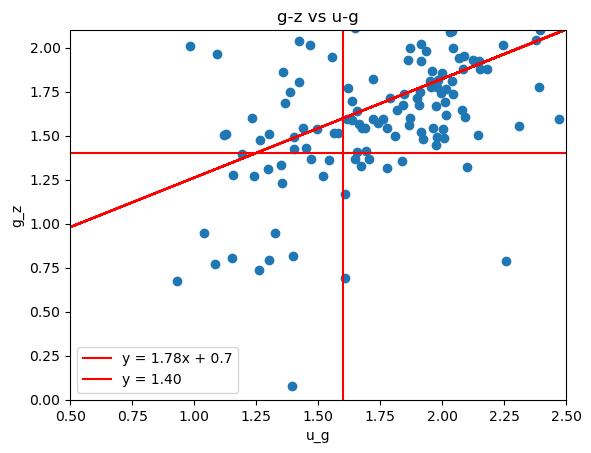

In [23]:
pairDf2 = brightDF1.loc[(brightDF1['modelMag_r'] < rmag_threshold) \
#                           & (brightDF1['u_g'] < 1.7) \
                          & (brightDF1['u_g'] < 2.3) \
                          & (brightDF1['g_z'] < 2.2) \
                          & (brightDF1['g_z'] > 1.6)]

# 1.6 < g_z < 2.2
# u_g > 1.7

top_slope = 1.78
bot_slope = 1.1
bot_intercept = -.20
top_intercept = .70

x1 = pairDf['u_g']
x2 = pairDf['g_z']

x3 = pairDf['modelMag_r']

plt.figure()
plt.plot(x1, x2, 'o')
plt.plot(top_slope*x1, x1 + top_intercept, 'r-', label = f'y = {str(top_slope)}x + {str(top_intercept)}')
# plt.plot(bot_slope*x1, x1 + bot_intercept, 'ro', label =  f'y = x + {str(bot_intercept)}')
plt.ylim(gz_lim)
plt.xlim(ug_lim)
# plt.axhline(y=1.65)
plt.axhline(y=1.40, color = 'r', label = 'y = 1.40')
plt.axvline(x=1.60, color = 'r')
plt.xlabel('u_g')
plt.ylabel('g_z')
plt.title('g-z vs u-g')
plt.legend()
plt.show()

In [24]:
def dra_dec(ra,dec,ra0,dec0) :
	''' calculate angular separation in RA and Dec,
    	given input coords and reference coords,
    	all in radians
	'''
	dra = (np.sin(ra - ra0) * np.cos(dec))
	ddec = -np.cos(ra - ra0) * np.cos(dec) * np.sin(dec0) + np.sin(dec) * np.cos(dec0)
	return np.array([dra, ddec]) # in radians

ra0, dec0 = 49.9506671, 41.5116961 # NGC 1275, from NED

clustCent_R = []
for ra, dec in zip(pairDf['ra'], pairDf['dec']):
    dra, ddec = dra_dec(np.radians(ra), np.radians(dec), np.radians(ra0), np.radians(dec0))
    R_clust = np.sqrt(dra**2+ddec**2) * 75e3
    clustCent_R.append(R_clust)
pairDf['ClusterCentRad'] = clustCent_R


KeyError: 'ra'

In [25]:
pairDf


,u_g,g_z,g_r,g_i,r_i,r_z,modelMag_r,labels
1,1.635536,1.695250,0.960300,1.370968,0.410667,0.734949,17.08435,0
4,2.246117,2.017632,1.125536,1.634195,0.508659,0.892096,18.87916,0
8,1.262079,0.737644,0.458859,0.649113,0.190254,0.278786,18.66884,0
11,1.302483,0.792460,0.511456,0.713074,0.201617,0.281004,15.49529,0
12,1.617607,2.170547,1.181578,1.761650,0.580072,0.988970,19.18396,0
...,...,...,...,...,...,...,...,...
219,1.302105,1.511499,0.821907,1.175476,0.353569,0.689592,19.37686,1
220,1.974316,1.445345,0.867374,1.316496,0.449122,0.577971,18.71980,1
222,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,14.49405,1
223,1.906456,1.674442,0.899385,1.351961,0.452576,0.775057,15.59959,1


In [ ]:
gz_slope = -14.3
gz_intercept1 = 37
gz_intercept2 = 46 # is this one intense enough?

## TODO -- Get classes on this plot
plt.figure()
xx = np.linspace(1, 2.5) 

plt.scatter(x2, x3, c = pairDf['ClusterCentRad'], vmin = 100, vmax = 1000)
plt.plot(xx, xx*gz_slope + gz_intercept1, 'b--', label = f'y = {str(gz_slope)}x + {str(gz_intercept1)}')
plt.plot(xx, xx*gz_slope + gz_intercept2, 'b-', label = f'y = {str(gz_slope)}x + {str(gz_intercept2)}')
plt.ylim(modMagr_lim)
# # plt.xlim(gz_lim)
plt.xlim((-1, 3))
# plt.axvline(x=1.90, color = 'r')
# plt.axvline(x=1.85, color = 'r', label = 'x = 1.85')
# plt.axvline(x=1.30, color = 'r', label = 'x = 1.30')
# plt.axvline(x=1.575, color = 'r', label = 'x = 1.575')
plt.colorbar()
plt.ylabel('modelMag_r')
plt.xlabel('g_z')
plt.title('PCC Brights : $R_{mag}$ vs g-z')
plt.legend()
plt.show()

In [26]:
pcc_crossmatchQuery = '''CREATE TABLE #upload ( up_id int, up_ra float, up_dec float ) 
INSERT INTO #upload values ( 1, 49.43464, 40.87648),( 2, 50.71059, 40.90011),( 3, 50.43778, 40.96237),( 4, 50.55783, 40.95394),( 5, 50.27557, 40.97107),( 6, 49.08633, 40.97127),( 7, 50.33284, 40.99509),( 8, 50.01600, 41.05777),( 9, 50.52619, 41.08242),( 10, 49.26452, 41.09188),( 11, 49.54948, 41.23287),( 12, 49.81257, 41.23137),( 13, 50.71703, 41.24594),( 14, 49.71770, 41.26755),( 15, 50.34345, 41.27714),( 16, 49.61810, 41.28606),( 17, 49.42728, 41.32309),( 18, 48.92604, 41.31836),( 19, 50.14164, 41.37964),( 20, 49.78269, 41.41263),( 21, 50.33074, 41.41562),( 22, 49.21440, 41.45938),( 23, 50.06715, 41.48258),( 24, 50.34479, 41.50313),( 25, 49.01468, 41.52288),( 26, 49.51195, 41.51297),( 27, 50.28064, 41.53824),( 28, 50.47216, 41.56143),( 29, 50.49371, 41.57921),( 30, 49.42844, 41.59988),( 31, 49.86271, 41.60818),( 32, 49.39353, 41.62147),( 33, 49.79257, 41.67811),( 34, 50.49710, 41.78499),( 35, 49.48984, 41.77585),( 36, 50.63848, 41.79206),( 37, 49.60997, 41.81874),( 38, 49.44231, 41.93492),( 39, 50.32299, 41.97126),( 40, 50.56341, 41.97293),( 41, 50.02595, 42.00451),( 42, 49.78714, 42.13901),( 43, 50.17779, 42.20089),( 44, 49.48429, 42.20973),( 45, 49.70962, 42.31499),( 46, 50.35571, 40.90381),( 47, 49.84918, 41.09801),( 48, 50.07848, 41.09704),( 49, 50.48358, 41.10194),( 50, 49.76534, 41.19418),( 51, 50.32510, 41.40939),( 52, 48.87942, 41.48487),( 53, 50.02964, 41.53824),( 54, 50.12943, 41.56757),( 55, 49.24521, 41.68621),( 56, 50.18575, 42.03045)
create table #x (up_id int,objID bigint)
INSERT INTO #x 
SELECT up_id, dbo.fGetNearestObjIdEq(up_ra,up_dec,0.5) as objId 
     FROM #upload WHERE dbo.fGetNearestObjIdEq(up_ra,up_dec,0.5) IS NOT NULL 
SELECT
p.objID, 
dbo.fPhotoTypeN(p.type) as type,
p.ra, p.dec,
p.modelMag_r, 
p.modelMag_u - p.modelMag_g as u_g, 
p.modelMag_g - p.modelMag_z as g_z, 
p.modelMag_g - p.modelMag_r as g_r, 
p.modelMag_g - p.modelMag_i as g_i, 
p.modelMag_r - p.modelMag_i as r_i, 
p.modelMag_r - p.modelMag_z as r_z, 
p.flags, dbo.fPhotoFlagsN(p.flags) as flag_text
FROM #upload u
JOIN #x x ON x.up_id = u.up_id
JOIN PhotoTag p ON p.objID = x.objID 
ORDER BY x.up_id
'''
pcc_crossDf = CasJobs.executeQuery(pcc_crossmatchQuery, "dr16")
# crossDf

In [27]:
# crossDf

In [28]:
SH_MDG = pd.read_csv('..\Sheets\SH_MDG.csv')

md_gz = pcc_crossDf['g_z']
md_rMag = pcc_crossDf['modelMag_r']

common_x = list(set(x2.to_list()).intersection(md_gz))
common_y = list(set(x3.to_list()).intersection(md_rMag))

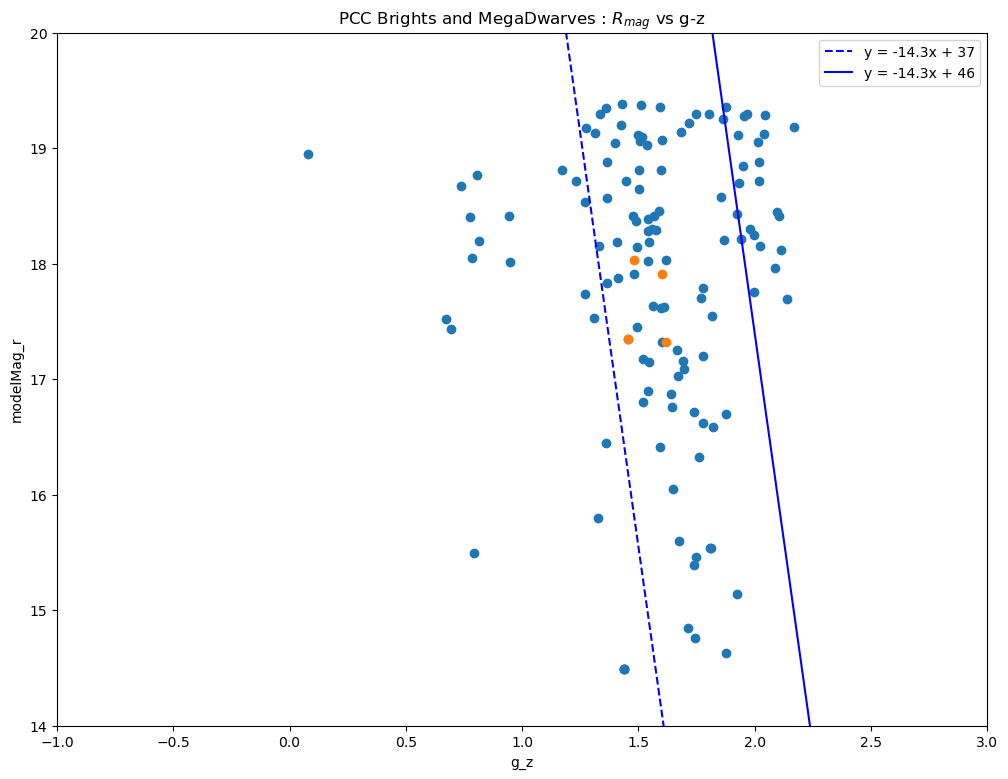

In [31]:
gz_slope = -14.3
gz_intercept1 = 37
gz_intercept2 = 46 # is this one intense enough?


plt.figure(figsize = (12, 9))
plt.plot(x2, x3, '.', ms = 12)
# plt.plot(md_gz, md_rMag, 'r.')
xx = np.linspace(1, 2.5) 

plt.plot(common_x, common_y, '.', ms = 12)
# plt.scatter(x2, x3, c = pairDf['ClusterCentRad'], vmin = 100, vmax = 1000)
plt.plot(xx, xx*gz_slope + gz_intercept1, 'b--', label = f'y = {str(gz_slope)}x + {str(gz_intercept1)}')
plt.plot(xx, xx*gz_slope + gz_intercept2, 'b-', label = f'y = {str(gz_slope)}x + {str(gz_intercept2)}')
plt.ylim(modMagr_lim)
# # plt.xlim(gz_lim)
plt.xlim((-1, 3))
# plt.axvline(x=1.90, color = 'r')
# plt.axvline(x=1.85, color = 'r', label = 'x = 1.85')
# plt.axvline(x=1.30, color = 'r', label = 'x = 1.30')
# plt.axvline(x=1.575, color = 'r', label = 'x = 1.575')
# plt.colorbar()
plt.ylabel('modelMag_r')
plt.xlabel('g_z')
plt.title('PCC Brights and MegaDwarves : $R_{mag}$ vs g-z')
plt.legend()
plt.show()